## overview
- predict performance at next step given next domain to practice on

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import wandb
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
import random

Initialize run

Data

In [123]:
df = pd.read_csv("data/filtered_ds.csv")

In [124]:
df["start_time_min"] = df["start_time_min"].astype('datetime64[ns]')
df = df.sort_values(by=["patient_id", "start_time_min"])

Create training data

In [125]:
def process_row(row):
    values_a = [float(x.strip()) for x in str(row['domain_ids']).split(',')]
    values_b = [float(x.strip()) for x in str(row['domain_scores']).split(',')]
    return values_a, values_b

In [126]:
## given a dataframe of a single patient, order the sessions by time and returns a dataframe with 14 domain scores
def create_training_data(data : pd.DataFrame):
    score = np.zeros((1, 14)) # continously updated to whatever the newest score is
    scores = np.zeros((len(data), 14)) # remove the last since we dont have target data for it
    domain_code = np.zeros((len(data), 14))
    patient_ids = data["patient_id"].to_numpy().reshape(-1, 1)[1:]
    i = 0 # keeps track of number of rows

    data = data.sort_values(by=["start_time_min"])

    for idx, row in data.iterrows():
        domains, domain_scores = process_row(row)
        for j in range(len(domains)):
            score[0, int(domains[j] - 1)] = domain_scores[j]
        # encode domain worked on
        for d in domains:
            domain_code[i, int(d - 1)] = 1
        # set score
        scores[i, :] = score
        i += 1

    
    prev_score = scores[:-1, :]
    next_score = scores[1:, :]
    domain_code = domain_code[1:, :]

    scores = np.hstack((patient_ids, domain_code))
    scores = np.hstack((scores, prev_score))
    scores = np.hstack((scores, next_score))
    
    scores_df = pd.DataFrame(scores, columns=["patient_id"] + ["domain %d encoding" % i for i in range(1, 15)] + ["domain %d score" % i for i in range(1, 15)] + ["domain %d target" % i for i in range(1, 15)])
    scores_df.reset_index(drop=True, inplace=True)
    return scores_df

In [127]:
data = df.groupby("patient_id")[df.columns].apply(create_training_data).reset_index(drop=True)

In [128]:
## pick a random patient for case study
pid = random.choice(pd.unique(data["patient_id"]))
# pid = 281737
## save the patient's data
case_study_data = copy.deepcopy(data[data['patient_id'] == pid])
## remove the patient's data from the dataset
model_data = data.drop(data[data['patient_id'] == pid].index)

## reset index for the case study
case_study_data = case_study_data.reset_index(drop=True)

In [129]:
model_data = model_data.drop(["patient_id"], axis=1)

In [130]:
def filter_nonzero_rows(df, max_zeros, column_names=["domain %d score" %i for i in range(1, 15)]):
    # only use the score columns when counting 0s
    scores = df[column_names]
    # Count number of zeros in each row
    zeros_count = (scores == 0).sum(axis=1)
    
    # Filter rows with at most max_zeros number of zeros
    non_zero_rows = df[zeros_count <= max_zeros]
    return non_zero_rows

In [131]:
model_data = filter_nonzero_rows(model_data, 0)

In [132]:
def generate_random_array(rows, cols, N):
    if N > cols:
        raise ValueError("N cannot be greater than the number of columns.")
    
    # Create an array of ones with the desired shape
    array = np.ones((rows, cols), dtype=int)
    
    # Randomly assign N zeros to each row
    for i in range(rows):
        indices = np.random.choice(cols, N, replace=False)
        array[i, indices] = 0
    
    return array, array.shape[0] * N

In [133]:
def generate_mask(data, N=10):
    rows, cols = data.shape
    assert(cols == 14)
    mask, n_zeros = generate_random_array(rows, cols, N)
    data = copy.deepcopy(data)
    return data * mask, n_zeros, mask

In [134]:
score_columns = ["domain %d score" %i for i in range(1, 15)]
encoding_columns = ["domain %d encoding" %i for i in range(1, 15)]
target_columns = ["domain %d target" %i for i in range(1, 15)]

In [135]:
target = copy.deepcopy(model_data[target_columns])
model_data[score_columns], _, _ = generate_mask(model_data[score_columns])

In [136]:
model_data = copy.deepcopy(model_data[encoding_columns + score_columns])
model_data = model_data.to_numpy()
target = target.to_numpy()

In [137]:
def create_missing_indicator(data):
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            if p == 0:
                # print("shouldn't be here")
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    return copy.deepcopy(temp)

In [138]:
model_data_scores = create_missing_indicator(model_data[:, -14:])
model_data = np.hstack((model_data[:, :14], model_data_scores))
# target = create_missing_indicator(target)

In [139]:
model_data.shape

(135931, 42)

In [140]:
model_data[0]

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 1.   , 0.   , 0.   , 1.   , 1.   , 0.   , 0.   ,
       1.   , 1.   , 1.   , 1.   , 0.   , 0.   , 0.569, 0.431, 0.45 ,
       0.55 , 0.   , 0.   , 0.7  , 0.3  , 1.   , 1.   , 1.   , 1.   ,
       0.   , 0.   , 1.   , 1.   , 0.26 , 0.74 ])

Model

In [141]:
## input : 14 domain encodings + 14 domains (28 total features with missing indicator)
## output: 28 score (prediction for the scores after next domain
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        hidden1 = 100
        hidden2 = 25
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 3, hidden1),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden1, hidden2),
            torch.nn.Sigmoid()
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden2, hidden1),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden1, n_domains)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

masking

In [142]:
def missing(arr):
    assert(len(arr) == 2)
    # if two values are the same (the only three possible values pairs are (0, 0), (1, 1), and (0.5, 0.5))
    return arr[0] == arr[1] and (arr[0] == 0 or arr[0] == 1)

Training

In [143]:
def train_model(x_train, x_val,y_train, y_val, epochs, model, optimizer, loss_function):
    outputs = []
    losses = []
    val_losses = []
    w = 14 ## hardcoded

    for epoch in range(epochs):
        epoch_loss = []
        val_epoch_loss = []
        ## training
        model.train()
        for i in range(len(x_train)):
            session = x_train[i]
            # Output of Autoencoder
            session_rs = session.reshape(-1, w * 3) # 3 times for encoding, values, missing indicators
            session_t = torch.from_numpy(session_rs).float()
            reconstructed = model(session_t)
            
            target = copy.deepcopy(y_train[i].reshape(-1, w))
            target = torch.from_numpy(target).float()

            # Calculating the loss function
            loss = loss_function(reconstructed, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Storing the losses in a list for plotting
            epoch_loss.append(loss.item())

        losses.append(statistics.mean(epoch_loss))
        outputs.append((epochs, session_t, reconstructed))

        ## validation
        model.eval()
        with torch.no_grad():
            for k in range(len(x_val)):
                val = x_val[k]
                val_rs = val.reshape(-1, w * 3)
                val_t = torch.from_numpy(val_rs)
                val_t = val_t.clone().detach().type(torch.float32)
                answer = model(val_t)
                val_loss = loss_function(answer, torch.from_numpy(y_val[k].reshape(-1, w)).type(torch.float32))
                val_epoch_loss.append(val_loss.item())
        val_losses.append(statistics.mean(val_epoch_loss))
    return losses, val_losses, outputs, model

In [144]:
num_runs = 5

In [145]:
losses_2d = []
val_losses_2d = []
for i in range(num_runs):
    model = NN()
    epochs = 10
    lr = 0.0075

    # Validation using MSE Loss function
    loss_function = torch.nn.MSELoss()
    
    # Using an Adam Optimizer
    optimizer = torch.optim.Adam(model.parameters(),
                                lr = lr)
    
    x_train, x_val, y_train, y_val = train_test_split(model_data, target, test_size=0.50)
    model.eval()
    with torch.no_grad():
        predictions = model(torch.from_numpy(x_train).float())
        zero_loss = loss_function(predictions, torch.from_numpy(y_train).float())

        predictions = model(torch.from_numpy(x_val).float())
        zero_loss_val = loss_function(predictions, torch.from_numpy(y_val).float())
    
    losses, val_losses, outputs, model = train_model(x_train, x_val, y_train, y_val, epochs, model, optimizer, loss_function)
    losses = [zero_loss.item()] + losses
    val_losses = [zero_loss_val.item()] + val_losses
    
    losses_2d.append(losses)
    val_losses_2d.append(val_losses)

In [146]:
def plot_mean_and_std(data, color_choice="blue", setting=""):
    """
    Plots the mean and standard deviation across multiple lists of data.
    
    Parameters:
    - data (list of lists): A list where each element is a list of numbers.
    
    The function will compute the mean and standard deviation at each point
    across the lists and plot these as a line for the mean and shading for the
    standard deviation.
    """
    # Convert data to a NumPy array for easier manipulation
    data_array = np.array(data)
    
    # Calculate mean and standard deviation
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    # print(means, stds)
    
    # Create the x-axis values
    x_values = np.arange(len(means))
    
    # Plotting
    plt.plot(x_values, means, label='Mean', color=color_choice)  # Mean line
    plt.fill_between(x_values, means - stds, means + stds, color=color_choice, alpha=0.2, label='Standard Deviation')
    
    plt.title('Mean and Standard Deviation Plot of %s' %setting)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)

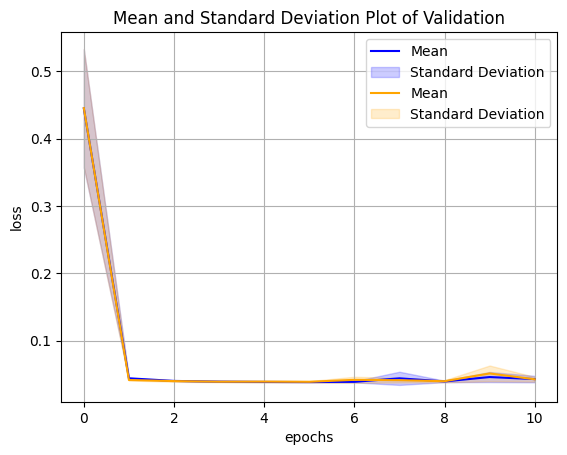

In [147]:
# Defining the Plot Style

# Plotting
with torch.no_grad():
    plot_mean_and_std(losses_2d, "blue", "Training")
    plot_mean_and_std(val_losses_2d, "orange", "Validation")

# wandb.log(
#     {
#         "train val loss": wandb.plot.line_series(
#             xs=range(1, epochs + 1),
#             ys=[losses, val_losses],
#             keys=["Train", "Validation"],
#             title="training and validation loss",
#             xname="epochs",
#         )
#     }
# )

In [148]:
def enhanced_box_plot(data_array):
    """
    Creates a box plot for each column in the given NumPy array and overlays mean and standard deviation.
    
    Parameters:
    - data_array (numpy.ndarray): A 2D NumPy array where each column represents a series of data points.
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    # Create the boxplot
    bp = ax.boxplot(data_array, patch_artist=True, notch=True, meanline=True)
    
    # Calculate means and standard deviations
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    n_cols = data_array.shape[1]

    # Add mean and standard deviation lines
    for i in range(n_cols):
        # Mean line
        plt.plot([i+1], [means[i]], color='red', marker='o', markersize=5)
        # Standard deviation lines
        plt.plot([i+1, i+1], [means[i] - stds[i], means[i] + stds[i]], color='purple', marker='_', markersize=10, linestyle='None')

    # Customizing the plot
    plt.title('Box Plot with Mean and Standard Deviation')
    plt.xlabel('Column Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

# enhanced_box_plot(model_data[:, 0::2])

In [149]:
np.mean(x_train, axis=0)

array([0.08467594, 0.1650114 , 0.04287501, 0.13378945, 0.21572868,
       0.05392481, 0.04168322, 0.00793055, 0.13452512, 0.07274332,
       0.03628338, 0.19340837, 0.14001324, 0.03372324, 0.51263808,
       0.48600828, 0.50578999, 0.49281223, 0.59940066, 0.3992457 ,
       0.48820187, 0.50982653, 0.44030988, 0.55838062, 0.53830011,
       0.46414232, 0.52234043, 0.47763015, 0.56740237, 0.43000806,
       0.46801304, 0.52698439, 0.52060868, 0.47840552, 0.60074949,
       0.40058944, 0.48133173, 0.5191391 , 0.5278537 , 0.4627444 ,
       0.57496969, 0.43007702])

### Visualization
- visualize individual patient's trajectory (ground truth vs prediction vs imputation?)
- looks at overall score and next domain error

In [150]:
column_names = ["domain %d score" % i for i in range(1, 15)]
column_rename_dict = {}
for i in range(len(column_names)):
    column_rename_dict[column_names[i]] = i + 1

In [151]:
# takes in a matrix, returns a list mean along rows
def get_score(data):
    return np.mean(data, axis=1)

In [152]:
# get ground truth scores (overall)
GT_scores = get_score(case_study_data[column_names].to_numpy())

In [153]:
# get prediction scores
model.eval()
with torch.no_grad():
    test_data = case_study_data[encoding_columns + score_columns].to_numpy()
    test_data_scores = create_missing_indicator(test_data[:, -14:])
    test_data = np.hstack((test_data[:, :14], test_data_scores))
    predictions = model(torch.from_numpy(test_data).type(torch.float32)).detach().numpy()

In [154]:
n_missing = np.sum(case_study_data[encoding_columns].to_numpy())
target_ = np.multiply(case_study_data[target_columns].to_numpy(), case_study_data[encoding_columns].to_numpy()) # only the targets we want to predict
prediction_ = np.multiply(predictions, case_study_data[encoding_columns].to_numpy()) # only the scores we want to predict
mse_ = np.sum(np.abs(target_ - prediction_))/n_missing

In [155]:
mse_

0.09519482291182248

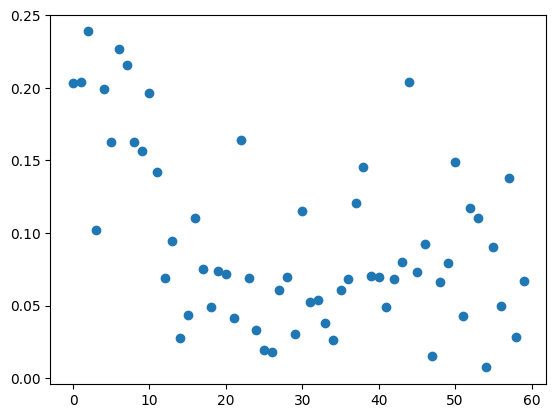

In [162]:
plt.figure()
plt.scatter(range(case_study_data.shape[0]), np.divide(np.sum(np.abs(target_ - prediction_), axis=1), np.sum(case_study_data[encoding_columns].to_numpy(), axis=1)))

In [157]:
np.sum(case_study_data[encoding_columns].to_numpy(), axis=1)

array([2., 2., 1., 3., 1., 2., 1., 1., 2., 2., 3., 1., 2., 2., 1., 3., 2.,
       2., 2., 2., 2., 2., 2., 3., 2., 1., 2., 1., 2., 2., 2., 2., 2., 1.,
       2., 1., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 1., 1., 2., 2.,
       2., 2., 2., 1., 2., 2., 2., 1., 2.])

In [158]:
case_study_data[encoding_columns]

,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,domain 10 encoding,domain 11 encoding,domain 12 encoding,domain 13 encoding,domain 14 encoding
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [159]:
df[df.patient_id == pid]

,id,patient_id,domain_ids,domain_scores,start_time_min
838790,11764751,187842,6,0.7370,2018-06-08 19:02:50
838768,11764752,187842,"3,13","0.4000,0.4240",2018-06-08 19:07:12
838774,11764753,187842,"3,12","0.4000,0.2500",2018-06-08 19:14:07
838808,11764754,187842,10,0.2500,2018-06-08 19:15:47
838764,11764755,187842,"1,10,11","0.3570,0.2500,0.8000",2018-06-09 07:05:32
...,...,...,...,...,...
838800,12602271,187842,"6,10","0.4840,0.4070",2018-08-10 06:33:17
838815,12602273,187842,"10,11","0.3430,0.7600",2018-08-11 17:54:36
838789,12602274,187842,"3,12","0.4000,0.2280",2018-08-14 06:45:11
838817,12602275,187842,12,0.2280,2018-08-23 06:33:24


In [168]:
np.unique(df[df.patient_id == pid]["domain_ids"])

array(['1', '1,10,11', '10', '10,11', '12', '3,12', '3,13', '6', '6,10',
       '6,7'], dtype=object)

In [160]:
create_training_data(df[df.patient_id == pid])

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 5 target,domain 6 target,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target
0,187842.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.737,0.000,0.0,0.0,0.000,0.00,0.000,0.424,0.0
1,187842.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.737,0.000,0.0,0.0,0.000,0.00,0.250,0.424,0.0
2,187842.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.737,0.000,0.0,0.0,0.250,0.00,0.250,0.424,0.0
3,187842.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.737,0.000,0.0,0.0,0.250,0.80,0.250,0.424,0.0
4,187842.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.737,0.000,0.0,0.0,0.250,0.80,0.250,0.424,0.0
5,187842.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.737,0.000,0.0,0.0,0.250,0.80,0.232,0.424,0.0
6,187842.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.737,0.000,0.0,0.0,0.167,0.80,0.232,0.424,0.0
7,187842.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.711,0.000,0.0,0.0,0.167,0.80,0.232,0.424,0.0
8,187842.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.711,0.000,0.0,0.0,0.167,0.80,0.232,0.424,0.0
9,187842.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.711,0.000,0.0,0.0,0.167,0.80,0.250,0.424,0.0
